In [0]:
# !nvidia-smi

In [3]:
!pip --quiet install transformers
!pip --quiet install tokenizers

     |████████████████████████████████| 645kB 2.7MB/s 
     |████████████████████████████████| 1.1MB 14.0MB/s 
     |████████████████████████████████| 3.8MB 19.1MB/s 
     |████████████████████████████████| 890kB 22.9MB/s 


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!cp -r '/content/drive/My Drive/Colab Notebooks/Tweet Sentiment Extraction/Scripts/.' .

In [0]:
COLAB_BASE_PATH = '/content/drive/My Drive/Colab Notebooks/Tweet Sentiment Extraction/'
MODEL_BASE_PATH = COLAB_BASE_PATH + 'Models/Files/145-roBERTa_base/'

import os
os.mkdir(MODEL_BASE_PATH)

## Dependencies

In [10]:
import json, warnings, shutil
from tweet_utility_scripts import *
from tweet_utility_preprocess_roberta_scripts import *
from transformers import TFRobertaModel, RobertaConfig
from tokenizers import ByteLevelBPETokenizer
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers, metrics, losses, layers

SEED = 0
seed_everything(SEED)
warnings.filterwarnings("ignore")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Load data

In [11]:
database_base_path = COLAB_BASE_PATH + 'Data/aux/'
k_fold = pd.read_csv(database_base_path + '5-fold.csv')
display(k_fold.head())

# Unzip files
!tar -xvf '/content/drive/My Drive/Colab Notebooks/Tweet Sentiment Extraction/Data/aux/fold_1.tar.gz'
!tar -xvf '/content/drive/My Drive/Colab Notebooks/Tweet Sentiment Extraction/Data/aux/fold_2.tar.gz'
!tar -xvf '/content/drive/My Drive/Colab Notebooks/Tweet Sentiment Extraction/Data/aux/fold_3.tar.gz'
# !tar -xvf '/content/drive/My Drive/Colab Notebooks/Tweet Sentiment Extraction/Data/aux/fold_4.tar.gz'
# !tar -xvf '/content/drive/My Drive/Colab Notebooks/Tweet Sentiment Extraction/Data/aux/fold_5.tar.gz'

,textID,text,selected_text,sentiment,jaccard,text_len,selected_text_len,text_wordCnt,selected_text_wordCnt,fold_1,fold_2,fold_3,fold_4,fold_5
0,cb774db0d1,"i`d have responded, if i were going","i`d have responded, if i were going",neutral,1.000000,35,35,7,7,train,train,train,validation,train
1,549e992a42,sooo sad i will miss you here in san diego!!!,sooo sad,negative,0.200000,45,8,10,2,validation,train,train,train,train
2,088c60f138,my boss is bullying me...,bullying me,negative,0.166667,25,11,5,2,train,validation,train,train,train
3,9642c003ef,what interview! leave me alone,leave me alone,negative,0.600000,30,14,5,3,train,validation,train,train,train
4,358bd9e861,"sons of ****, why couldn`t they put them on th...","sons of ****,",negative,0.214286,74,13,14,3,train,train,validation,train,train


fold_1/
fold_1/y_valid.npy
fold_1/x_valid_aux.npy
fold_1/y_train_mask.npy
fold_1/x_train_aux.npy
fold_1/x_valid.npy
fold_1/x_valid_aux2.npy
fold_1/y_valid_aux.npy
fold_1/y_train.npy
fold_1/y_train_aux.npy
fold_1/y_valid_mask.npy
fold_1/x_train.npy
fold_1/x_train_aux2.npy
fold_2/
fold_2/y_valid.npy
fold_2/x_valid_aux.npy
fold_2/y_train_mask.npy
fold_2/x_train_aux.npy
fold_2/x_valid.npy
fold_2/x_valid_aux2.npy
fold_2/y_valid_aux.npy
fold_2/y_train.npy
fold_2/y_train_aux.npy
fold_2/y_valid_mask.npy
fold_2/x_train.npy
fold_2/x_train_aux2.npy
fold_3/
fold_3/y_valid.npy
fold_3/x_valid_aux.npy
fold_3/y_train_mask.npy
fold_3/x_train_aux.npy
fold_3/x_valid.npy
fold_3/x_valid_aux2.npy
fold_3/y_valid_aux.npy
fold_3/y_train.npy
fold_3/y_train_aux.npy
fold_3/y_valid_mask.npy
fold_3/x_train.npy
fold_3/x_train_aux2.npy


# Model parameters

In [0]:
vocab_path = COLAB_BASE_PATH + 'qa-transformers/roberta/roberta-base-vocab.json'
merges_path = COLAB_BASE_PATH + 'qa-transformers/roberta/roberta-base-merges.txt'
base_path = COLAB_BASE_PATH + 'qa-transformers/roberta/'

config = {
  "MAX_LEN": 96,
  "BATCH_SIZE": 32,
  "EPOCHS": 5,
  "LEARNING_RATE": 3e-5,
  "ES_PATIENCE": 1,
  "question_size": 4,
  "N_FOLDS": 3,
  "base_model_path": base_path + 'roberta-base-tf_model.h5',
  "config_path": base_path + 'roberta-base-config.json'
}

with open(MODEL_BASE_PATH + 'config.json', 'w') as json_file:
    json.dump(json.loads(json.dumps(config)), json_file)

# Tokenizer

In [0]:
tokenizer = ByteLevelBPETokenizer(vocab_file=vocab_path, merges_file=merges_path, 
                                  lowercase=True, add_prefix_space=True)

## Learning rate schedule

Learning rate schedule: 3e-05 to 3e-05 to 1.87e-06


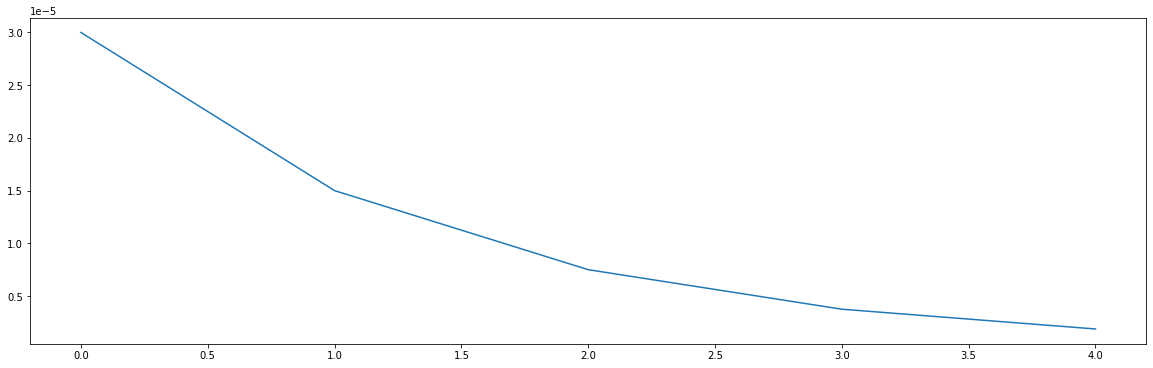

In [14]:
LR_MIN = 1e-6
LR_MAX = config['LEARNING_RATE']
LR_EXP_DECAY = .5

@tf.function
def lrfn(epoch):
    lr = LR_MAX * LR_EXP_DECAY**epoch
    if lr < LR_MIN:
        lr = LR_MIN
    return lr
    
rng = [i for i in range(config['EPOCHS'])]
y = [lrfn(x) for x in rng]

fig, ax = plt.subplots(figsize=(20, 6))
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

# Model

In [0]:
module_config = RobertaConfig.from_pretrained(config['config_path'], output_hidden_states=False)

def model_fn(MAX_LEN):
    input_ids = layers.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_ids')
    attention_mask = layers.Input(shape=(MAX_LEN,), dtype=tf.int32, name='attention_mask')
    input_sentiment = layers.Input(shape=(3,), dtype=tf.float32, name='input_sentiment')
    
    base_model = TFRobertaModel.from_pretrained(config['base_model_path'], config=module_config, name="base_model")
    last_hidden_state, _ = base_model({'input_ids': input_ids, 'attention_mask': attention_mask})
    
    x_start_negative = layers.Dropout(.1)(last_hidden_state)
    x_start_negative = layers.Dense(1)(x_start_negative)
    x_start_negative = layers.Flatten()(x_start_negative)
    y_start_negative = layers.Activation('softmax', name='y_start_negative')(x_start_negative)
    y_start_negative = layers.Multiply()([y_start_negative, input_sentiment[:,0]])
    
    x_start_neutral = layers.Dropout(.1)(last_hidden_state)
    x_start_neutral = layers.Dense(1)(x_start_neutral)
    x_start_neutral = layers.Flatten()(x_start_neutral)
    y_start_neutral = layers.Activation('softmax', name='y_start_neutral')(x_start_neutral)
    y_start_neutral = layers.Multiply()([y_start_neutral, input_sentiment[:,1]])
    
    x_start_positive = layers.Dropout(.1)(last_hidden_state)
    x_start_positive = layers.Dense(1)(x_start_positive)
    x_start_positive = layers.Flatten()(x_start_positive)
    y_start_positive = layers.Activation('softmax', name='y_start_positive')(x_start_positive)
    y_start_positive = layers.Multiply()([y_start_positive, input_sentiment[:,2]])

    y_start_sum = layers.Add(name='y_start_avg')([y_start_negative, y_start_neutral, y_start_positive])
    
    x_start = layers.Dropout(.1)(last_hidden_state)
    x_start = layers.Dense(1)(x_start)
    x_start = layers.Flatten()(x_start)
    y_start = layers.Activation('softmax')(x_start)
    y_start = layers.Average(name='y_start')([y_start, y_start_sum])

    x_end_negative = layers.Dropout(.1)(last_hidden_state)
    x_end_negative = layers.Dense(1)(x_end_negative)
    x_end_negative = layers.Flatten()(x_end_negative)
    y_end_negative = layers.Activation('softmax', name='y_end_negative')(x_end_negative)
    y_end_negative = layers.Multiply()([y_end_negative, input_sentiment[:,0]])

    x_end_neutral = layers.Dropout(.1)(last_hidden_state)
    x_end_neutral = layers.Dense(1)(x_end_neutral)
    x_end_neutral = layers.Flatten()(x_end_neutral)
    y_end_neutral = layers.Activation('softmax', name='y_end_neutral')(x_end_neutral)
    y_end_neutral = layers.Multiply()([y_end_neutral, input_sentiment[:,1]])

    x_end_positive = layers.Dropout(.1)(last_hidden_state)
    x_end_positive = layers.Dense(1)(x_end_positive)
    x_end_positive = layers.Flatten()(x_end_positive)
    y_end_positive = layers.Activation('softmax', name='y_end_positive')(x_end_positive)
    y_end_positive = layers.Multiply()([y_end_positive, input_sentiment[:,2]])

    y_end_sum = layers.Add(name='y_end_avg')([y_end_negative, y_end_neutral, y_end_positive])

    x_end = layers.Dropout(.1)(last_hidden_state)
    x_end = layers.Dense(1)(x_end)
    x_end = layers.Flatten()(x_end)
    y_end = layers.Activation('softmax')(x_end)
    y_end = layers.Average(name='y_end')([y_end, y_end_sum])
    
    model = Model(inputs=[input_ids, attention_mask, input_sentiment], outputs=[y_start, y_end])
    
    return model

# Train

In [0]:
def get_training_dataset(x_train, y_train, batch_size, buffer_size, seed=0):
    dataset = tf.data.Dataset.from_tensor_slices(({'input_ids': x_train[0], 'attention_mask': x_train[1], 'input_sentiment': x_train[2]}, 
                                                  {'y_start': y_train[0],'y_end': y_train[1]}))
    dataset = dataset.repeat()
    dataset = dataset.shuffle(2048, seed=seed)
    dataset = dataset.batch(batch_size, drop_remainder=True)
    dataset = dataset.prefetch(buffer_size)
    return dataset

def get_validation_dataset(x_valid, y_valid, batch_size, buffer_size, repeated=False, seed=0):
    dataset = tf.data.Dataset.from_tensor_slices(({'input_ids': x_valid[0], 'attention_mask': x_valid[1], 'input_sentiment': x_valid[2]}, 
                                                  {'y_start': y_valid[0],'y_end': y_valid[1]}))
    if repeated:
        dataset = dataset.repeat()
        dataset = dataset.shuffle(2048, seed=seed)
    dataset = dataset.batch(batch_size, drop_remainder=True)
    dataset = dataset.cache()
    dataset = dataset.prefetch(buffer_size)
    return dataset

def get_test_dataset(x_test, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices({'input_ids': x_test[0], 'attention_mask': x_test[1], 'input_sentiment': x_test[2]})
    dataset = dataset.batch(batch_size)
    return dataset

In [18]:
AUTO = tf.data.experimental.AUTOTUNE
strategy = tf.distribute.get_strategy()
history_list = []

for n_fold in range(config['N_FOLDS']):
    n_fold +=1
    print('\nFOLD: %d' % (n_fold))
    # Load data
    base_data_path = 'fold_%d/' % (n_fold)
    x_train = np.load(base_data_path + 'x_train.npy')
    x_train_aux2 = np.load(base_data_path + 'x_train_aux2.npy')
    y_train = np.load(base_data_path + 'y_train.npy')
    x_valid = np.load(base_data_path + 'x_valid.npy')
    x_valid_aux2 = np.load(base_data_path + 'x_valid_aux2.npy')
    y_valid = np.load(base_data_path + 'y_valid.npy')
    
    step_size = x_train.shape[1] // config['BATCH_SIZE']
    valid_step_size = x_valid.shape[1] // config['BATCH_SIZE']

    # Build TF datasets
    train_dist_ds = strategy.experimental_distribute_dataset(get_training_dataset((*x_train, x_train_aux2), y_train, config['BATCH_SIZE'], AUTO, seed=SEED))
    valid_dist_ds = strategy.experimental_distribute_dataset(get_validation_dataset((*x_valid, x_valid_aux2), y_valid, config['BATCH_SIZE'], AUTO, repeated=True, seed=SEED))
    train_data_iter = iter(train_dist_ds)
    valid_data_iter = iter(valid_dist_ds)
    
    # Step functions
    @tf.function
    def train_step(data_iter):
        def train_step_fn(x, y):
            with tf.GradientTape() as tape:
                probabilities = model(x, training=True)
                loss_start = loss_fn_start(y['y_start'], probabilities[0], label_smoothing=0.2)
                loss_end = loss_fn_end(y['y_end'], probabilities[1], label_smoothing=0.2)
                loss = tf.math.add(loss_start, loss_end)
            grads = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))
            # update metrics
            train_loss.update_state(loss)
            train_loss_start.update_state(loss_start)
            train_loss_end.update_state(loss_end)
        for _ in tf.range(step_size):
            strategy.experimental_run_v2(train_step_fn, next(data_iter))

    @tf.function
    def valid_step(data_iter):
        def valid_step_fn(x, y):
            probabilities = model(x, training=False)
            loss_start = loss_fn_start(y['y_start'], probabilities[0])
            loss_end = loss_fn_end(y['y_end'], probabilities[1])
            loss = tf.math.add(loss_start, loss_end)
            # update metrics
            valid_loss.update_state(loss)
            valid_loss_start.update_state(loss_start)
            valid_loss_end.update_state(loss_end)
        for _ in tf.range(valid_step_size):
            strategy.experimental_run_v2(valid_step_fn, next(data_iter))

    # Train model
    model_path = 'model_fold_%d.h5' % (n_fold)
    
    model = model_fn(config['MAX_LEN'])
    optimizer = optimizers.Adam(learning_rate=lambda: lrfn(tf.cast(optimizer.iterations, tf.float32)//step_size))
    loss_fn_start = losses.categorical_crossentropy
    loss_fn_end = losses.categorical_crossentropy

    train_loss = metrics.Sum()
    valid_loss = metrics.Sum()
    train_loss_start = metrics.Sum()
    valid_loss_start = metrics.Sum()
    train_loss_end = metrics.Sum()
    valid_loss_end = metrics.Sum()
        
    metrics_dict = {'loss': train_loss, 'loss_start': train_loss_start, 'loss_end': train_loss_end, 
                    'val_loss': valid_loss, 'val_loss_start': valid_loss_start, 'val_loss_end': valid_loss_end}
        
    history = custom_fit(model, metrics_dict, train_step, valid_step, train_data_iter, valid_data_iter, 
                         step_size, valid_step_size, config['BATCH_SIZE'], config['EPOCHS'], config['ES_PATIENCE'], 
                         (MODEL_BASE_PATH + model_path), save_last=False)
    
    history_list.append(history)
    model.save_weights(MODEL_BASE_PATH +'last_' + model_path)
    model.load_weights(MODEL_BASE_PATH + model_path)

    
    # Make predictions
    train_preds = model.predict(get_test_dataset((*x_train, x_train_aux2), config['BATCH_SIZE']))
    valid_preds = model.predict(get_test_dataset((*x_valid, x_valid_aux2), config['BATCH_SIZE']))
    
    k_fold.loc[k_fold['fold_%d' % (n_fold)] == 'train', 'start_fold_%d' % (n_fold)] = train_preds[0].argmax(axis=-1)
    k_fold.loc[k_fold['fold_%d' % (n_fold)] == 'train', 'end_fold_%d' % (n_fold)] = train_preds[1].argmax(axis=-1)
    k_fold.loc[k_fold['fold_%d' % (n_fold)] == 'validation', 'start_fold_%d' % (n_fold)] = valid_preds[0].argmax(axis=-1)
    k_fold.loc[k_fold['fold_%d' % (n_fold)] == 'validation', 'end_fold_%d' % (n_fold)] = valid_preds[1].argmax(axis=-1)
    
    k_fold['end_fold_%d' % (n_fold)] = k_fold['end_fold_%d' % (n_fold)].astype(int)
    k_fold['start_fold_%d' % (n_fold)] = k_fold['start_fold_%d' % (n_fold)].astype(int)
    k_fold['end_fold_%d' % (n_fold)].clip(0, k_fold['text_len'], inplace=True)
    k_fold['start_fold_%d' % (n_fold)].clip(0, k_fold['end_fold_%d' % (n_fold)], inplace=True)
    k_fold['prediction_fold_%d' % (n_fold)] = k_fold.apply(lambda x: decode(x['start_fold_%d' % (n_fold)], x['end_fold_%d' % (n_fold)], x['text'], config['question_size'], tokenizer), axis=1)
    k_fold['prediction_fold_%d' % (n_fold)].fillna(k_fold["text"], inplace=True)
    k_fold['jaccard_fold_%d' % (n_fold)] = k_fold.apply(lambda x: jaccard(x['selected_text'], x['prediction_fold_%d' % (n_fold)]), axis=1)


FOLD: 1
Train for 687 steps, validate for 171 steps

EPOCH 1/5
time: 275.4s loss: 4.4776 loss_start: 2.2049 loss_end: 2.2727 val_loss: 1.9568 val_loss_start: 0.9983 val_loss_end: 0.9585
Saved model weights at "/content/drive/My Drive/Colab Notebooks/Tweet Sentiment Extraction/Models/Files/145-roBERTa_base/model_fold_1.h5"

EPOCH 2/5
time: 266.3s loss: 4.0564 loss_start: 2.0382 loss_end: 2.0182 val_loss: 1.9308 val_loss_start: 1.0001 val_loss_end: 0.9307
Saved model weights at "/content/drive/My Drive/Colab Notebooks/Tweet Sentiment Extraction/Models/Files/145-roBERTa_base/model_fold_1.h5"

EPOCH 3/5
time: 266.8s loss: 3.9535 loss_start: 1.9902 loss_end: 1.9633 val_loss: 1.8620 val_loss_start: 0.9486 val_loss_end: 0.9134
Saved model weights at "/content/drive/My Drive/Colab Notebooks/Tweet Sentiment Extraction/Models/Files/145-roBERTa_base/model_fold_1.h5"

EPOCH 4/5
time: 266.8s loss: 3.8831 loss_start: 1.9665 loss_end: 1.9167 val_loss: 1.8234 val_loss_start: 0.9373 val_loss_end: 0.88

# Model loss graph

Fold: 1


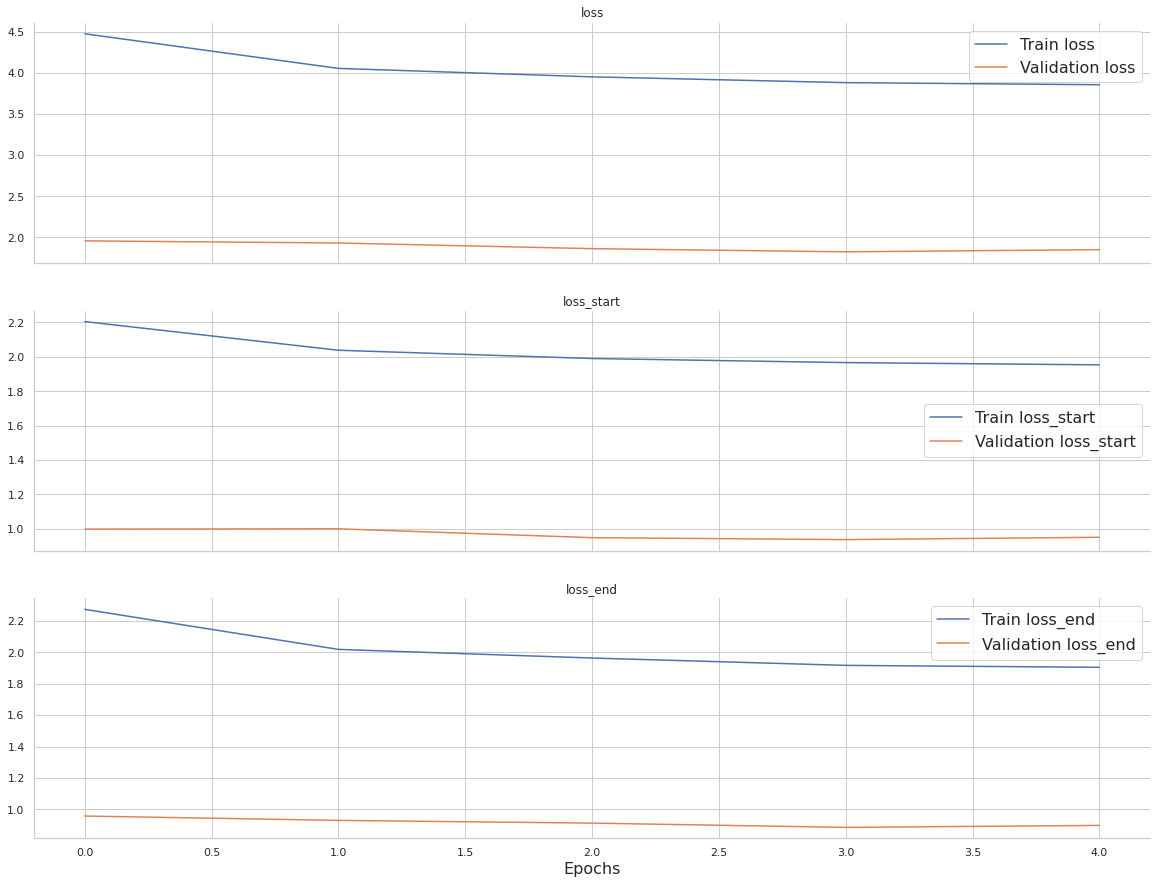

Fold: 2


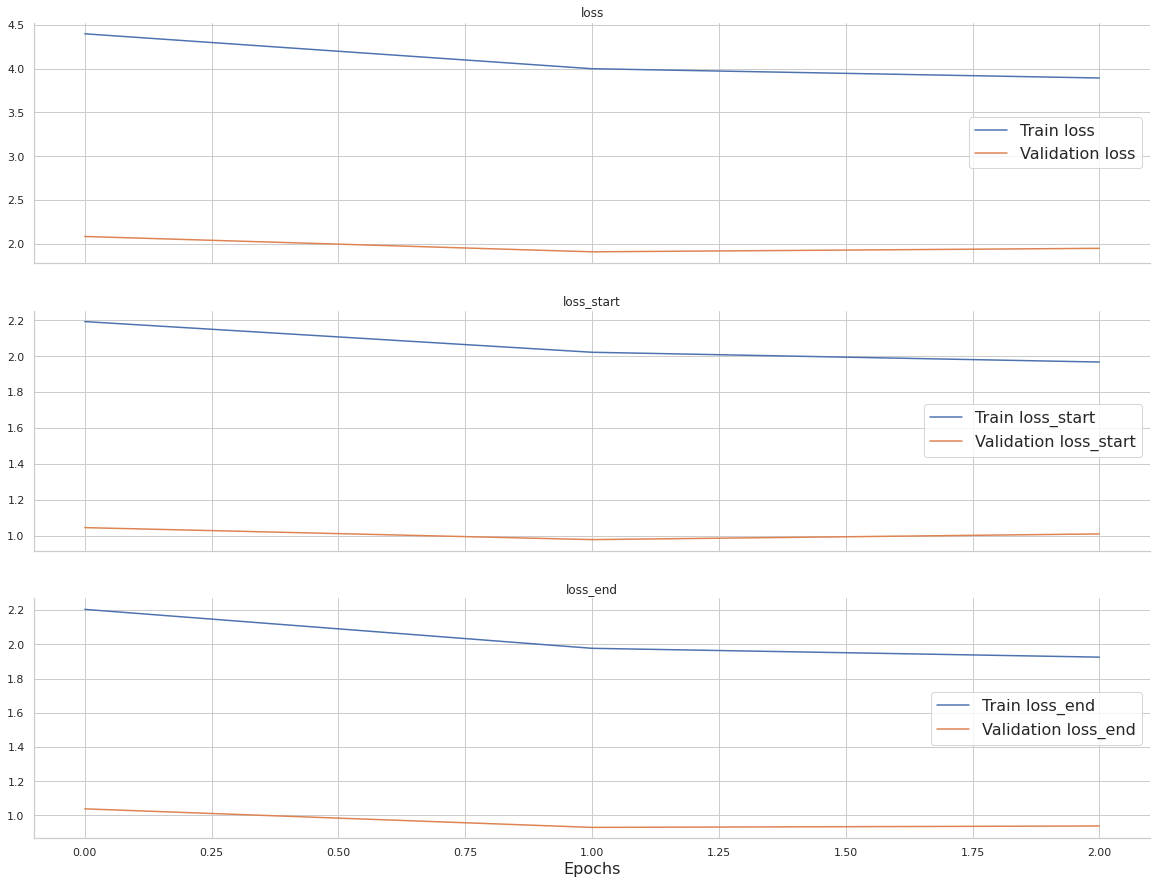

Fold: 3


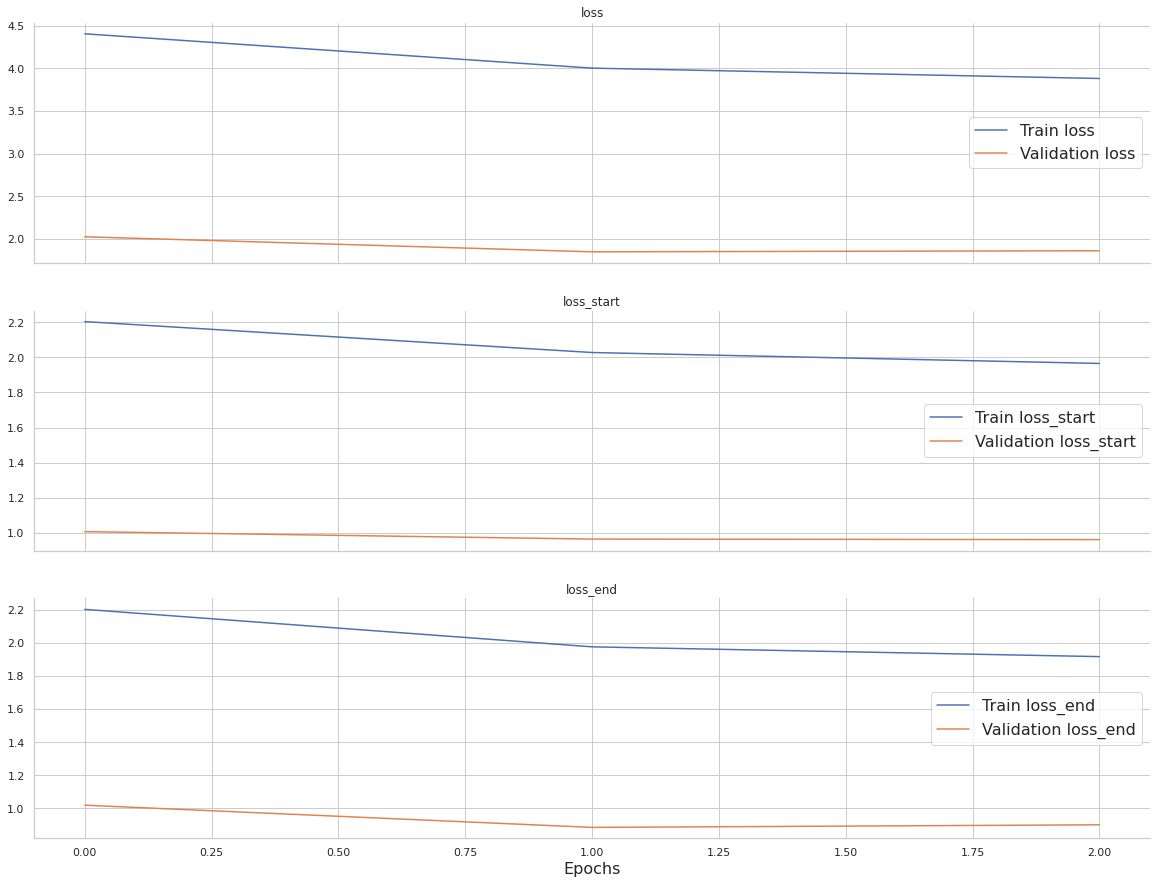

In [19]:
sns.set(style="whitegrid")
for n_fold in range(config['N_FOLDS']):
    print('Fold: %d' % (n_fold+1))
    plot_metrics(history_list[n_fold])

# Model evaluation

In [20]:
display(evaluate_model_kfold(k_fold, config['N_FOLDS']).style.applymap(color_map))

,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3
Metric/Jaccard,,,,,,,,,
Overall,0.737839,0.708187,0.029652,0.744422,0.711701,0.735921,0.700824,0.733174,0.712036
Sentiment negative,0.584652,0.527135,0.057518,0.597063,0.527890,0.578764,0.519096,0.578130,0.534417
Sentiment neutral,0.973529,0.973464,0.000065,0.974152,0.974119,0.972565,0.972880,0.973870,0.973393
Sentiment positive,0.571434,0.528635,0.042799,0.580473,0.538270,0.571898,0.513012,0.561931,0.534621
0 <= text wordCnt < 3,0.858888,0.847135,0.011753,0.867424,0.824627,0.853453,0.859823,0.855786,0.856955
3 <= text wordCnt < 10,0.788675,0.771596,0.017079,0.795784,0.763816,0.783679,0.767685,0.786562,0.783286
10 <= text wordCnt < 30,0.706457,0.670922,0.035536,0.713177,0.678955,0.705996,0.662634,0.700199,0.671176
30 <= text wordCnt < 100,0.667876,0.564508,0.103368,0.652421,0.676179,0.691994,0.456030,0.659212,0.561314
0 <= selected text wordCnt < 3,0.708103,0.647697,0.060407,0.719588,0.651825,0.705996,0.643449,0.698726,0.647817


# Visualize predictions

In [21]:
display(k_fold[[c for c in k_fold.columns if not (c.startswith('textID') or 
                                                  c.startswith('text_len') or 
                                                  c.startswith('selected_text_len') or 
                                                  c.startswith('text_wordCnt') or 
                                                  c.startswith('selected_text_wordCnt') or 
                                                  c.startswith('fold_') or 
                                                  c.startswith('start_fold_') or 
                                                  c.startswith('end_fold_'))]].head(15))

,text,selected_text,sentiment,jaccard,prediction_fold_1,jaccard_fold_1,prediction_fold_2,jaccard_fold_2,prediction_fold_3,jaccard_fold_3
0,"i`d have responded, if i were going","i`d have responded, if i were going",neutral,1.000000,"i`d have responded, if i were going",1.000000,"i`d have responded, if i were going",1.000000,"i`d have responded, if i were going",1.000000
1,sooo sad i will miss you here in san diego!!!,sooo sad,negative,0.200000,sooo sad,1.000000,sad,0.500000,sooo sad,1.000000
2,my boss is bullying me...,bullying me,negative,0.166667,bullying me...,0.333333,bullying me...,0.333333,bullying me...,0.333333
3,what interview! leave me alone,leave me alone,negative,0.600000,leave me alone,1.000000,leave me alone,1.000000,leave me alone,1.000000
4,"sons of ****, why couldn`t they put them on th...","sons of ****,",negative,0.214286,"sons of ****,",1.000000,"sons of ****,",1.000000,"sons of ****,",1.000000
5,http://www.dothebouncy.com/smf - some shameles...,http://www.dothebouncy.com/smf - some shameles...,neutral,1.000000,http://www.dothebouncy.com/smf - some shameles...,1.000000,http://www.dothebouncy.com/smf - some shameles...,1.000000,http://www.dothebouncy.com/smf - some shameles...,1.000000
6,2am feedings for the baby are fun when he is a...,fun,positive,0.071429,fun,1.000000,fun,1.000000,fun,1.000000
7,soooo high,soooo high,neutral,1.000000,soooo high,1.000000,soooo high,1.000000,soooo high,1.000000
8,both of you,both of you,neutral,1.000000,both of you,1.000000,both of you,1.000000,both of you,1.000000
9,journey!? wow... u just became cooler. hehe.....,wow... u just became cooler.,positive,0.500000,wow... u just became cooler.,1.000000,wow...,0.200000,wow...,0.200000
